In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.3.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
bi

In [3]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets
import tensorflow as tf
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
gpus


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [6]:
#bringing in the datasets 
#aur sirf train split hie lena hai toh likha hai
ds=tfds.load('fashion_mnist',split='train')

In [7]:
ds.as_numpy_iterator().next()['label']

2

In [8]:
#importing numpy as visualizing the data
import numpy as np

In [9]:
#setting up iterator
dataiterator=ds.as_numpy_iterator()

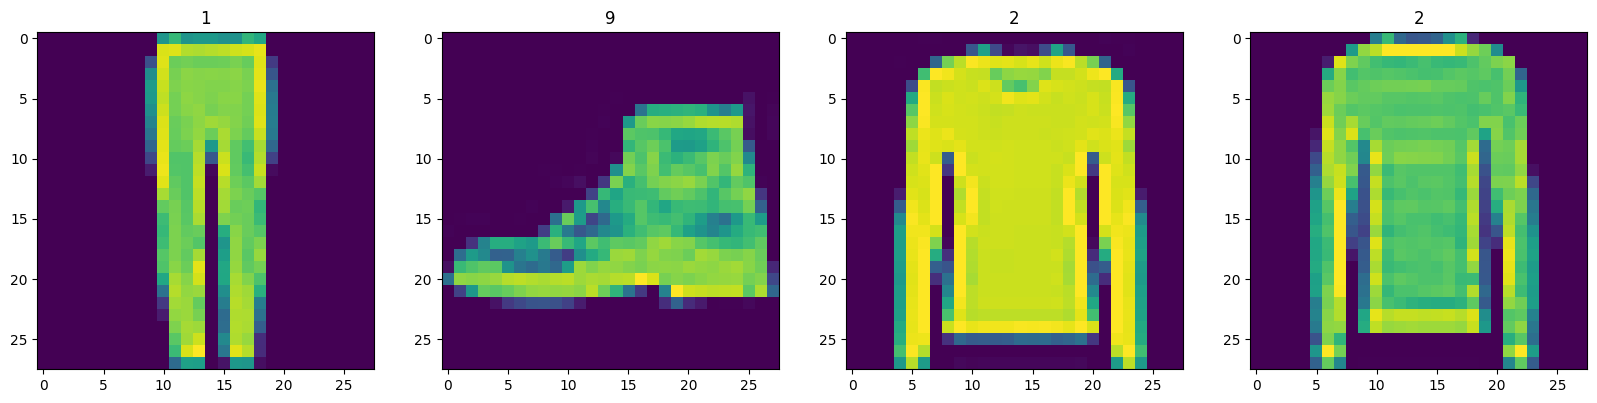

In [11]:
#creating subplots
fig,ax=plt.subplots(ncols=4,figsize=(20,20)) #setting up format fig=whole figure ax=subplot
for idx in range(4):
    sample=dataiterator.next() #taking one image at a time
    ax[idx].imshow(np.squeeze(sample['image'])) #squeezing to convert image from 28X28X1 to 28X28
    ax[idx].title.set_text(sample['label'])

In [12]:
#for setting good scale and to convert all the values between 0 and 1
def scale_images(data):
    image=data['image']
    return image/255

In [13]:
#steps we have to follow map,cache,shuffle,batch,prefetch
ds=tfds.load('fashion_mnist',split='train') #reloaded the dataset
ds=ds.map(scale_images) #running images through scaling function
ds=ds.cache() #caching the dataset
ds=ds.shuffle(60000) #shuffling the dataset
ds=ds.batch(128) #making batches of 128 samples
ds=ds.prefetch(64) #reduces the likelness of bottleneck 

In [14]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

BUILDING THE NEURAL NETWORK(GENERATIVE ADVERSARIAL NEURAL NETWORK)

In [15]:
#IMPORTING MODELLING COMPONENTS
from tensorflow.keras.models import Sequential #sequential api 1input=1output
#bringing in layers for the neural network
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Reshape,LeakyReLU,Dropout,UpSampling2D

Building the Generator


In [16]:
def build_generator():
    model=Sequential()
    #taking in random values
    model.add(Dense(7*7*128,input_dim=128)) #128 random values to start from 7x7 is the resolution of the image we want to produce
    model.add(LeakyReLU(0.2)) #relu to cater for nonlinearity
    model.add(Reshape((7,7,128)))
    #upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2)) #now our image is of size 14x14x128
    #upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding='same'))
    model.add(LeakyReLU(0.2)) #now our image is of size 28x28x128
    #covolutional block 1
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))
    #convolutional block 2
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))
    #ADDING SO MANY LAYERS TO HAVE MORE PARAMETERS FOR THE NEURAL NETWORK TO LEARN FROM
    #convolutional layer to get to one channel
    model.add(Conv2D(1,4,padding='same',activation='sigmoid')) #sigmoid for values to be between 0 and 1
    
    return model

In [17]:
generator=build_generator()


In [18]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 3s 3s/step


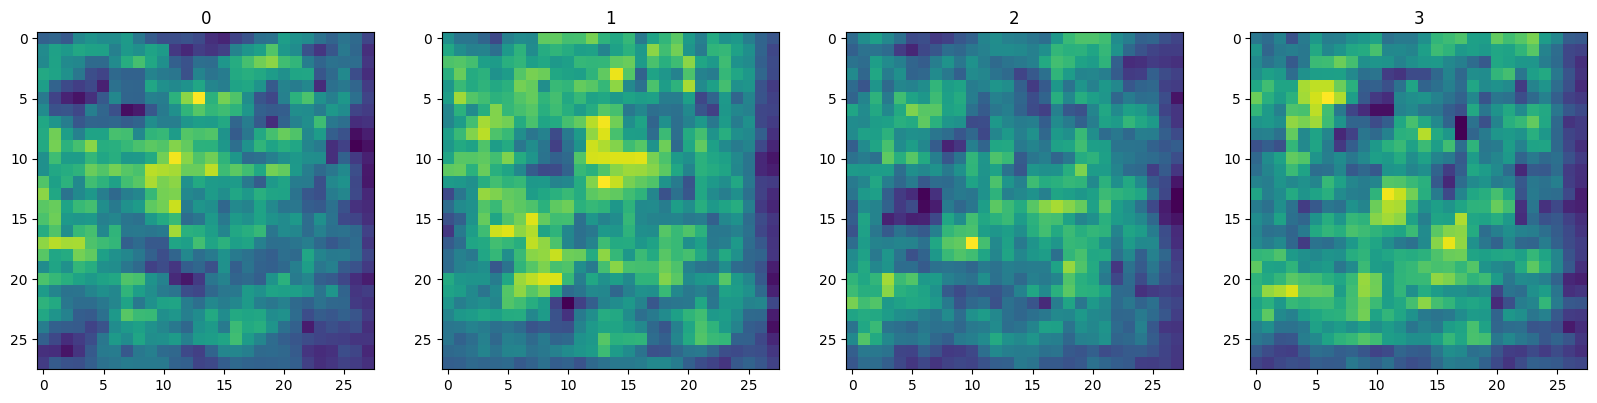

In [19]:
#output of our generator without training
img=generator.predict(np.random.randn(4,128,1))
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

BUILDING THE DISCRIMINATOR


In [20]:
def build_discriminator():
    model=Sequential()
    #first convolution layer
    model.add(Conv2D(32,5,input_shape=(28,28,1))) #passing through 32 filters(shape 5x5 of filter) 
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    #2nd convultion layer
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    #3rd convultion layer
    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    #4th convultion layer
    model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    #flatten and then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid'))
    return model

In [21]:
discriminator=build_discriminator()

In [22]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [23]:
discriminator.predict(np.expand_dims(img,0))

1/1 [==============================] - 0s 142ms/step


array([[0.48970333]], dtype=float32)

CONSTRUCTION TRAINING LOOP

In [24]:
#importing losses and optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [25]:
g_opt=Adam(learning_rate=0.0001) #generator optimzer
d_opt=Adam(learning_rate=0.00001) #discriminator optimzer
g_loss=BinaryCrossentropy()
d_loss=BinaryCrossentropy()

In [26]:
#importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [29]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [30]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [31]:
#CREATING AN INSTANT 
fashgan=FashionGAN(generator,discriminator)

In [32]:
#Compiling 
fashgan.compile(g_opt,d_opt,g_loss,d_loss)

Creating callback


In [33]:
import os #helps with folder navigation
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback #create callback at epoch end


In [34]:
#save examples of generate images
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

TRAINING OUR MODEL

In [40]:
hist=fashgan.fit(ds,epochs=500,callbacks=[ModelMonitor()])

TypeError: fit() got an unexpected keyword argument 'use_mutiprocessing'

Performance Review

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'],label='d_loss')
plt.plot(hist.history['g_loss'],label='g_loss')
plt.legend()
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

TESTING THE MODEL

In [ ]:
imgs=generator.predict(tf.random.normal((16,128,1)))

1/1 [==============================] - 0s 164ms/step


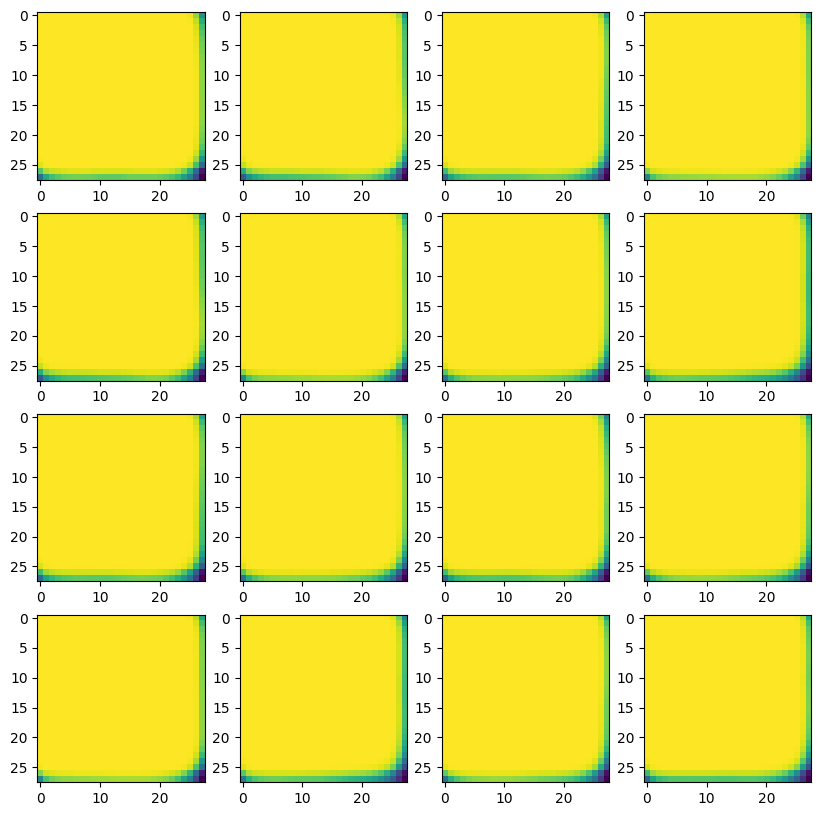

In [ ]:
fig,ax=plt.subplots(ncols=4,nrows=4,figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [ ]:
generator.save('gen1')
discriminator.save('dis1')

INFO:tensorflow:Assets written to: gen1\assets


INFO:tensorflow:Assets written to: gen1\assets


INFO:tensorflow:Assets written to: dis1\assets


INFO:tensorflow:Assets written to: dis1\assets
